## Introduction

There was a [GPS trajectory averaging challenge from the UEF Machine Learning group](http://cs.uef.fi/sipu/segments/). It seemed like a manageable and interesting little project, so I looked at it.

They supplied normalized trajectory training data in coordintates. The coordinates of the trajectories were 2D points with both x and y range from 0 to 1.

There are 100 sample groups and each group contains 3+ trajectories consisting of 2+ points. I am guessing the trajectories were actually measured GPS coords from user devices. The real trajectory or path from Openstreetmaps is also given.

## Input data

This is an example of a sample group with 12 trajectories. 

```
1. segment:
 x: [0.   0.44 0.55]
 y: [0.46 0.35 0.2 ]
2. segment:
 x: [0.18 0.29 0.38 0.46 0.53 0.62 0.72]
 y: [0.32 0.28 0.24 0.2  0.16 0.14 0.09]
3. segment:
 x: [0.23 0.33 0.39 0.52]
 y: [0.43 0.27 0.2  0.06]
4. segment:
 x: [0.77 0.62 0.49 0.35 0.2 ]
 y: [0.25 0.3  0.36 0.43 0.49]
5. segment:
 x: [0.77 0.59 0.43 0.28]
 y: [0.43 0.46 0.51 0.58]
6. segment:
 x: [0.81 0.68 0.55 0.42 0.33]
 y: [0.28 0.36 0.42 0.49 0.59]
7. segment:
 x: [0.21 0.33 0.45 0.57 0.69 0.81]
 y: [0.41 0.36 0.31 0.27 0.26 0.28]
8. segment:
 x: [1.   0.91 0.81 0.69 0.55 0.42 0.29]
 y: [0.68 0.75 0.81 0.85 0.87 0.9  0.92]
9. segment:
 x: [0.84 0.72 0.59 0.45 0.23]
 y: [0.32 0.36 0.4  0.45 0.57]
10. segment:
 x: [0.17 0.27 0.39 0.5  0.58 0.62]
 y: [0.57 0.58 0.52 0.47 0.37 0.25]
11. segment:
 x: [0.09 0.18 0.25 0.32 0.4  0.5  0.6 ]
 y: [0.28 0.24 0.2  0.16 0.11 0.06 0.  ]
12. segment:
 x: [0.7  0.59 0.47 0.35 0.23]
 y: [0.24 0.31 0.35 0.41 0.46]
```

Visually, it's (Green are the measured trajectories and black is the truth from OpenStreetMap):

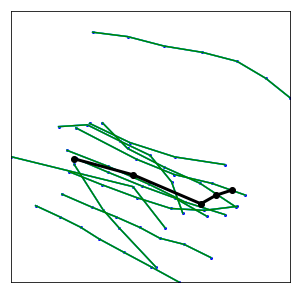

In [12]:
Image("basic.png")

## Implementation

I wrote it in Python 3. The only dependency is numpy. I tried to use the numpy arrauy operations wherever possible. I use a lot of the `linalg.norm` function, which is useful for computing eucledian distance.

My first idea was just to fit all the points by least squares and get intercept and slope of regression line. That had several problems:
* the trajectories might be vertical, causing the slope reach infinity. This could be fixed with converting it to angle with arctan.
* sometimes the trajectories and the true path curve - linear regression will not capture the curvature
* slope and intercept don't capture length, obviously an important factor of a geographical trajectory

I had to think harder to properly average arbitrary line segments. I came up with following. This is done for each sample group:
* Align the lines, so that they have the same direction (more on alignment below).
* Drop outliers (more on outlier detection below)
* Find median of the number of points in a line a sample group
* Define evenly linearly spaced list of \<median\> offsets, from 0 to 1. E.g. if the median was 6, the list of 6 offsets would be 
  \[0, .2, .4. .6. .8. 1\]
* Find points on every segment in a group, for every offset, and average the points on correspoding offsets.
* (2 previous bulletpoints are done in class Traj in my code)
* Resulting vector of averages is the segment average.
* Simplify the result line, i.e. drop points which don't add to curvature of the line. I use https://en.wikipedia.org/wiki/Ramer–Douglas–Peucker_algorithm for that.

The image below illustrates average of 2 (blue) lines. First line has 16 points (15 segments), second has 14 points (13 segments). Median is 15 - we define offset array `np.linspace(0,1,15)` and we get points on both of the lines on those offsets . 0 is the beginning and 1 is the end of the line. We then average the points, and we get 15-points result line (red).

I later found out that it's generally helpful to use more sample offsets that just the median. I use `median*10`.


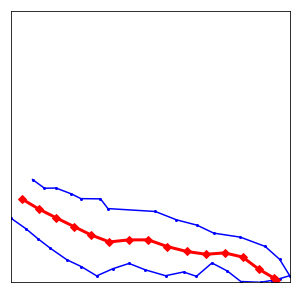

In [13]:
Image("warp.png")

I later found out that my averaging is maybe too similar to https://en.wikipedia.org/wiki/Dynamic_time_warping.

It's not a perfect solution, there are cases where it will not work well, but to tune further, I would need more training data.

Class Traj implements the offset evaluation. 

In [14]:
class Traj:
    def __init__(self,xsys):
        xs, ys = xsys
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.xd = np.diff(xs)
        self.yd = np.diff(ys)
        self.dists = np.linalg.norm([self.xd, self.yd],axis=0)
        self.cuts = np.cumsum(self.dists)
        self.d = np.hstack([0,self.cuts])

    # getPoints gets coordinates of offsets, e.g. for line [0,0][1,0][1,1] and offsets [.3, .7] would
    # return [.6,0][1,.4]. 
    # Resp. it would return [.6,1],[0,.4] becaseu x and y coords are returned
    # separate arrays (to make the numpy operations more effective)
    def getPoints(self, offsets):
        offdists = offsets * self.cuts[-1]
        ix = np.searchsorted(self.cuts, offdists)
        offdists -= self.d[ix]
        segoffs = offdists/self.dists[ix]
        x = self.xs[ix] + self.xd[ix]*segoffs
        y = self.ys[ix] + self.yd[ix]*segoffs
        return x,y


function getAvg implements the average of all lines in a group. `dismax` is max z-score for distance and `lenlim` is a tuple for (min_zscore_for_length, max_zscore_for_length). `eps` is epsilon for the Ramer–Douglas–Peucker algorithm (line smoothening factor).

In [15]:
    def getAvg(self, dismax, lenlim, eps):
        self.eps = eps
        self.endpoints()        
        self.getFiltered(dismax, lenlim)

        if len(self.filtix)<5:
            nbest = 4
            distrank = np.argsort(self.d)
            self.disoutix = distrank[nbest:]            
            self.lenoutix = []
            self.filtix = distrank[:nbest]
        filtered = [self.trajs[i] for i in self.filtix]
        trajLen = median([len(t.xs) for t in filtered])
        offs = np.linspace(0,1,trajLen*10)
        xm = []
        ym = []
        for t in filtered:
            xs, ys = t.getPoints(offs)            
            xm.append(xs)
            ym.append(ys)
        self.xp, self.yp = zip(*rdp(list(zip(np.mean(xm, axis=0),np.mean(ym, axis=0))), eps))

## Evaluating - measuring error

The training data contain ground truth, so it's good to define a way to measure solution error - some sort of distance between my aproximation and the true route.

Even though this task deals with line segments, it's not so straightforward how to measure error. The lines can have different number of segments and they can be oriented wrong. I came up with following:
* make sure the 2 lines are oriented the same
* to ensure we have same amount of segment, find 10 equally spaced points on the segments. Now we deal with 2 10-segment lines.
* find distance between each pair of points and sum it -> that is out error

I used the distance error in outlier detection.

In code:

In [16]:

# error between 2 segments: [x1,y2] and [x2,y2]
def disterr(x1,y1, x2, y2):
    sd = np.array([x1[0]-x2[0],y1[0]-y2[0]])
    ed = np.array([x1[0]-x2[-1],y1[0]-y2[-1]])
    # flip the 2nd line, if the lines are oriented differently
    if np.linalg.norm(sd) > np.linalg.norm(ed):
        x2 = np.flip(x2)
        y2 = np.flip(y2)

    offs = np.linspace(0,1,10)
    # Traj.getPoints() gets points from a line on given offsets
    xrs1, yrs1 = Traj((x1,y1)).getPoints(offs)
    xrs2, yrs2 = Traj((x2,y2)).getPoints(offs)
    return np.sum(np.linalg.norm([xrs1-xrs2, yrs1-yrs2],axis=0))


## Outlier Detection

The goal of outlier detection is to eliminate samples which are not believed to be helpful to proper approximation. If a line segment in a group is totally off, it's probably not going to contribute to a good approximation solution. I tried a couple of measures:

* slope and intercept of least-square regression line - This proved not robust enough, there are curved segments in the training.
* length of the line
* center distance of a line from the center of the average of all the lines
* curvature of the line - the extent of how straight or curved it is
* the `disterr` (from previous code) distace from "raw average" line of a segment. A "raw avergage" line is an average line without any outlier drop. Then, compute the `disterr` distances for each line in a group and drop those too far away

The idea was to find the most extreme values and throw them away. To define the throwaway threshold, I needed to use some normalized statistic measure. I thought about percentile, but then I learned about z-score. Z-score of a value from a distribution shows how extreme the value is. It's normalized in standard deviation units, so it's possible to use same limits for various measures.

I picked only the length and the `disterr` line distance in the end, the other measures didn't contribute much further. I pass the upper limit for distacne z-score and lower and upper limit for length z-scores to the averaging method listed above.

Following images illustrate outlier detection. The left image has length zscore limit (-1, 1) in cyan, and distance zscore limit (-9, .3) in green. The length limit says that lines shorter than 1 stddev from average length, and longer than 1 stddev from average length' will not be considered in solution. The distance limit says that lines with center further than 0.3 stddev from the center will not be considered in solution. The lower limit for distance is not considered - there's no issue for lines too close to the center.

Relaxing the limits for outlier can lead to worse solution. The right image has zscore limits (-1.5,1) for length, and (-9,2) for distance. The error is larger and it's also visually worse.

* green - lines dropped for distance extremity
* cyan - lines dropped for length extremity
* blue - lines used for approximation
* red - approximation
* black - truth


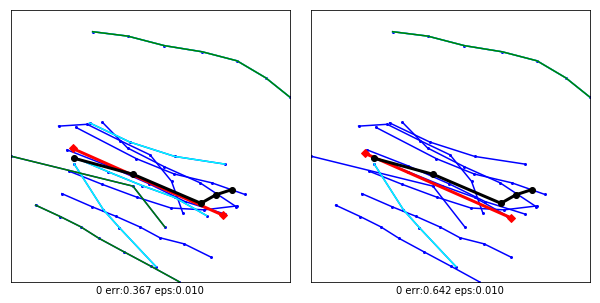

In [17]:
Image("outl.png")

## Alignment of orientation

The line segments in a group can have different orientation. This is very hard to understand from simple visualization, but with the offset averaging, it will soon start to show that the direction of the line segments must be aligned to work as expected. To illustrate the problem, following image shows how the line average is wrong for wrong orientation of 2 lines. On the left is the expected solution and on the right is the average of counter-oriented lines.

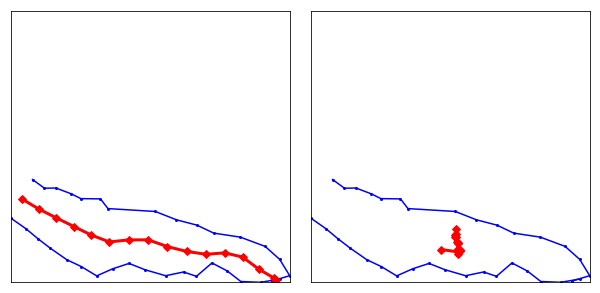

In [18]:
Image("ori.png")

I use a simplified 2-cluster K-means ("2-means" would probably be the proper term) algorithm, to find 2 clusters of endpoints - the two clusters are then used for orientiation.

First I compile list of termination points - 2 for each line in the proper order, so that it's \[startpoint\[l\] for l in lines\] ++ \[endpoint\[l\] for l in lines\]. The length of the list is 2\*len(lines).

Then I initialize 2 clusters with startpoint and endpoint of the first line (guaranteeing that the clusters contain different ends of measured trajectory). Then, based on distances to the center of the clusters, I label the (start- and end-) points, and then give it 10 more iterations, recalculating centers of the clusters, and relabeling accordingly.

In the end, I flip all the lines which have label "1" for startpoint. It's done only for the first half of the label list, because the second half are endpoints.

In [19]:
    def align(self):
        cs = np.array([[self.trajs[0].xs[0],self.trajs[0].xs[-1]],
                       [self.trajs[0].ys[0],self.trajs[0].ys[-1]]])
        xs = np.hstack([t.xs[0] for t in self.trajs] + [t.xs[-1] for t in self.trajs])
        ys = np.hstack([t.ys[0] for t in self.trajs] + [t.ys[-1] for t in self.trajs])
        clabs = []
        oldclabs = []
        for j in range(10):
            for i in range(len(xs)):
                ap = np.array([[xs[i]],[ys[i]]])
                dists = np.linalg.norm(ap - cs, axis=0)
                clabs.append(np.argmin(dists))
            cx = np.array([
                np.mean(xs[np.where(np.array(clabs)==0)]),
                np.mean(xs[np.where(np.array(clabs)==1)])])
            cy = np.array([
                np.mean(ys[np.where(np.array(clabs)==0)]),
                np.mean(ys[np.where(np.array(clabs)==1)])])
            if oldclabs == clabs:
                break
            oldclabs = clabs
            clabs = []
        for i,l in enumerate(clabs[:len(clabs)//2]):
            if l == 1:
                oldT = self.trajs[i]
                reversedTraj = (np.flip(oldT.xs), np.flip(oldT.ys))
                self.trajs[i] = Traj(reversedTraj)
       


## Conclusion

There is not enough of the training data to design a good averaging solution. Also, it's hard to measure the quality of the approximation when certain segment groups obviously off the correct trajectory. However, I understand this is a real world world problem, and IRL data are not perfect.

I experimentally found good values for the outlier detection. They are in the `seg.py` solution script.

Following picutre shows solutions in segment groups. Colors are
* black - ground truth
* red - average - my solution
* blue - lines used in solution
* green - lines dropped for being too far from the midline
* cyan - lines droppped for being too long or too short
* magenta - lines dropped for both reasons

The text below each picture says its number, `disterr` error of my solution from ground truth, total number of lines in a group, number of lines filtered for averaging, number of dropped lines.

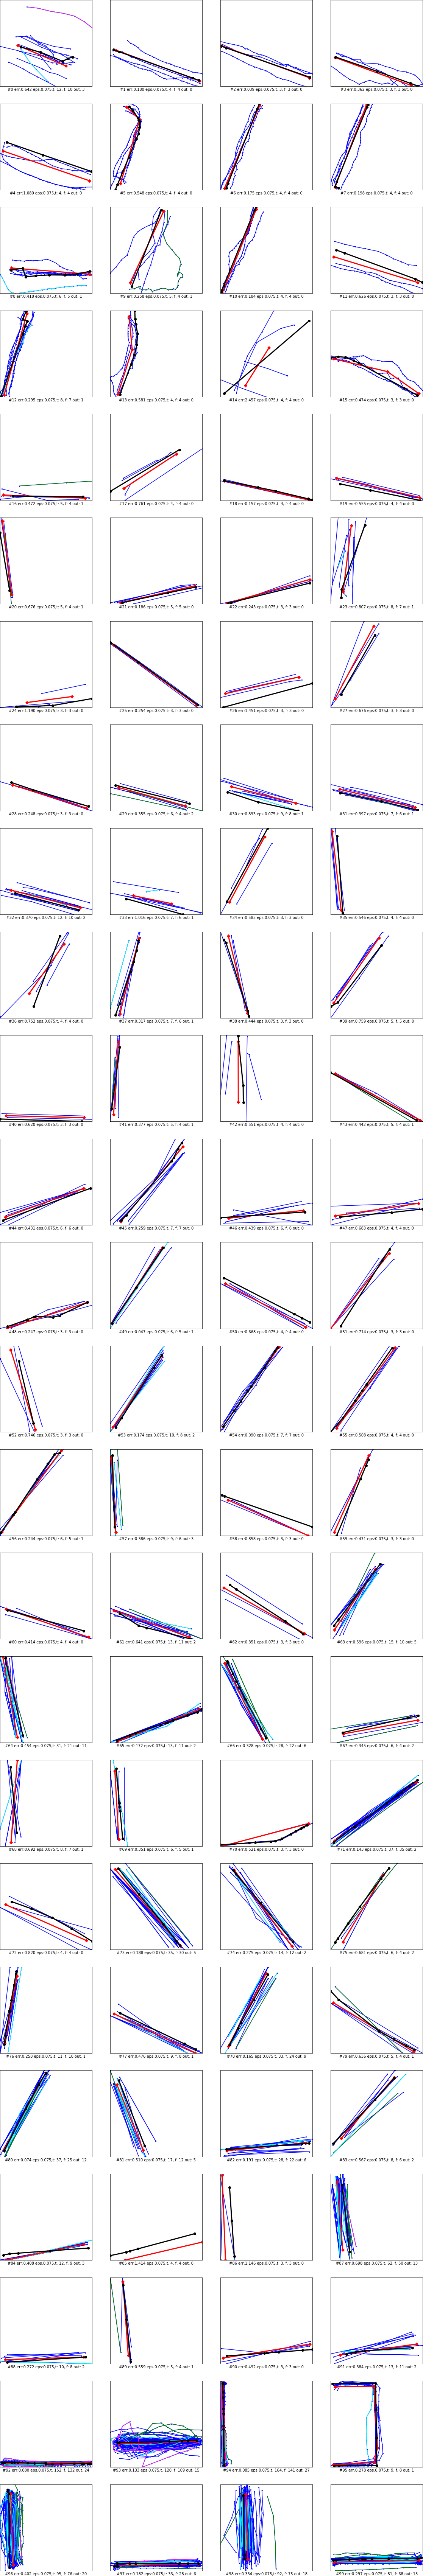

In [7]:
Image("all.png")